In [113]:
import os
from deepface import DeepFace
from deepface.modules import verification
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import numpy as np
from collections import Counter
import tensorflow as tf
import cv2

In [2]:
PATH = '/mnt/iDriveShare/Kayla/CBCT_images/anonymized/screenshots/'

In [3]:
def test_detector_backends(detectors, list_patients, indx, PATH):
    dict_undetected = {}
    for detector in detectors:
        print("Testing",detector,"...")
        num_undetected = 0
        for p in list_patients:
            for n in indx: 
                try:
                    image_path = PATH+p+"_"+n+".png"
                    detect = DeepFace.extract_faces(image_path, enforce_detection=True,detector_backend=detector)
                    # facial_area = detect[0]['facial_area']
                    # confidence = detect[0]['confidence']
    
                   
                except Exception as e:
                    num_undetected +=1
        dict_undetected[detector] = num_undetected
    return dict_undetected
            

In [4]:
def get_facial_embeddings(PATH,list_all, indx = ['1','2','A'],model='Facenet512',detector='retinaface'):
    emb_dict = {}
    for p in list_all:
        # print(p)
        emb_dict[p] = {}
        for n in indx:
            try:
                emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=True,detector_backend=detector,model_name=model) 
            except:
                print(p,n,": No face detected")
                emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=False,detector_backend=detector,model_name=model) 
                
    
    return emb_dict

In [170]:
def get_same_distances_dict(emb_dict, a, b, distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    for p in [p for p in list(emb_dict.keys()) if p not in skip]:
        print(p)
        v_a = emb_dict[p][a][0]['embedding']
        v_b = emb_dict[p][b][0]['embedding']
        # to do -- change 0 to be taken before
        dist =  verification.find_distance(v_a, v_b, distance_metric)
        dist_dict[p] = dist
        dist_list.append(dist)

    return dist_dict,dist_list

def get_diff_distances_dict(emb_dict,distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
    for p1 in [p for p in list(emb_dict.keys()) if p not in skip] :
        list_to_do.remove(p1)
        dist_dict[p1] = {}
        for p2 in list_to_do:            

            v_a = emb_dict[p1]['1'][0]['embedding']
            v_b = emb_dict[p2]['1'][0]['embedding']
            # to do -- change 0 to be taken before
            
            dist = verification.find_distance(v_a, v_b, distance_metric)
          
            dist_dict[p1][p2] = dist
            dist_list.append(dist)
        
    return dist_dict, dist_list


In [6]:
def plot_hist(same, diff,density=True,threshold=0.4):
    fig, ax1 = plt.subplots()
    
    # Plot histogram for 'Same Patient'
    color = 'blue'
    ax1.set_xlabel('Cosine Difference')
    ax1.set_ylabel('# of image pairs (Same Patient)', color=color)
    ax1.hist(same, bins=15, alpha=0.5, label='Same Patient', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

  
    
    # Create a second y-axis for 'Different Patient'
    ax2 = ax1.twinx()  
    color = 'red'
    ax2.set_ylabel('# of image pairs (Different Patient)', color=color)
    ax2.hist(diff, bins=30, alpha=0.5, label='Different Patient', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.axvline(x=threshold, color='gray', linestyle='--',label='Threshold')
    
    # Add legend and show plot
    fig.tight_layout()
    fig.legend(loc='center right', bbox_to_anchor=(0.85, 0.85))
    
    plt.show()

In [7]:
def plot_two_whiskers(same,diff,threshold=0.4):
    data = [same, diff]
    plt.rcParams['font.size'] = 12.
    # Create a figure instance
    fig = plt.figure(figsize=(5,5))
    
    # Create an axes instance
    ax = fig.add_axes([0,0,1,1])
    
    # Create the boxplot
    bp = ax.boxplot(data,patch_artist=True)#, vert=True, patch_artist=True, notch=True, bootstrap=5)
    
    colors = ['blue', 'red']
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    # Changing color and line width of whiskers
    for whisker in bp['whiskers']:
        whisker.set(color ='#8B008B',
                    linewidth = 1.5,
                    linestyle =":")
    
    # Changing color and line width of caps
    for cap in bp['caps']:
        cap.set(color ='black',
                linewidth = 2)
    
    ax.axhline(y=threshold, color='gray', linestyle='--',label='Threshold')
    
    ax.set_xticklabels(['CT1-CT2','CT1 to other patient'])
    plt.ylabel("Cosine Similarity")
    ax.set_ylim(ymin=0)
    
    handles, labels = ax.get_legend_handles_labels()
    custom_patches = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
    custom_labels = ['Same Patient', 'Different Patient']
    fig.legend(custom_patches + handles, custom_labels + labels, loc='upper left', bbox_to_anchor=(0.2, 0.95))
    fig.tight_layout()
  
    # show plot
    plt.show()

In [8]:
def get_optimal_threshold(list_same, list_diff):
    data = np.concatenate([list_same, list_diff])
    labels = np.concatenate([np.zeros(len(list_same)), np.ones(len(list_diff))])
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, data)
    
    # Find the optimal threshold (Youden's J statistic)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"The optimal threshold is: {optimal_threshold}")
    return optimal_threshold

In [9]:
def plot_3_x3(same_list,diff_list,anon_list,names=['Cosine Distance','Euclidean Distance','Euclidean L2 Distance'],threshold=0.4):
    
    if len(same_list) > 1:
        fig, axes = plt.subplots(1, len(same_list), figsize=(15, 5))  # 1 row, 3 columns
    else:
        fig = plt.figure(figsize=(5,5))
        # Create an axes instance
        ax = fig.add_axes([0,0,1,1])

    for i in range(len(same_list)):
        if len(same_list)> 1:
            ax = axes[i]
        # Create the boxplot
        data = [same_list[i], diff_list[i], anon_list[i]]
        bp = ax.boxplot(data, patch_artist=True)
        
        colors = ['blue', 'red','yellow']
        
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
        
        # Changing color and line width of whiskers
        for whisker in bp['whiskers']:
            whisker.set(color='#8B008B', linewidth=1.5, linestyle=":")

        # Changing color and line width of caps
        for cap in bp['caps']:
            cap.set(color='black', linewidth=2)
        
        ax.set_xticklabels(['CT1-CT2', 'CT1 to \n other patient','CT2 - \nAnon CT1'])
        ax.set_ylabel(names[i])
        ax.set_ylim(ymin=0)

        ax.axhline(y=threshold, color='green', linestyle='--', linewidth=2)
    
    plt.show()

In [10]:
def plot_hist_x3x3(same, diff, anon, names=['Cosine Difference','Euclidean Distance','Euclidean L2 Distance'], density=False, threshold=0.4):
    if len(same) > 1:
        fig, axes = plt.subplots(1, len(same), figsize=(15, 5))  # 1 row, 3 columns
    else:
        fig = plt.figure(figsize=(5,5))
        ax = fig.add_axes([0,0,1,1])

    # Determine common bin edges
    all_data = np.concatenate(same + diff + anon)
    bins = np.linspace(np.min(all_data), np.max(all_data), 30)

    for i in range(len(same)):
        if len(same) > 1:
            ax1, ax2 = axes[i], axes[i].twinx()
        else:
            ax1 = ax
            ax2 = ax.twinx()
        
        # Plot same and anon on the left axis
        ax2.hist(same[i], bins=bins, alpha=0.5, density=density, label='Same Patient', color='blue')
        ax2.hist(anon[i], bins=bins, alpha=0.5, density=density, label='Anon Patient', color='yellow')
        ax2.set_xlabel(names[i])
        ax2.set_ylabel('Number of image pairs (Same & Anon)')
        ax2.axvline(x=threshold, color='gray', linestyle='--', linewidth=2, label='Threshold')
        
        # Plot different on the right axis
        ax1.hist(diff[i], bins=bins, alpha=0.5, density=density, label='Different Patient', color='red')
        ax1.set_ylabel('Number of image pairs (Different)')
    
    # Combine legends and place it inside the plot on the right
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, loc='center right', bbox_to_anchor=(0.9, 0.9))
    
    fig.tight_layout()
    plt.show()


In [11]:
def get_same_distances_dict(emb_dict, a, b, distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    for p in [p for p in list(emb_dict.keys()) if p not in skip]:
        v_a = emb_dict[p][a][0]['embedding']
        v_b = emb_dict[p][b][0]['embedding']
        # to do -- change 0 to be taken before
        dist =  verification.find_distance(v_a, v_b, distance_metric)
        dist_dict[p] = dist
        dist_list.append(dist)

    return dist_dict,dist_list

def get_diff_distances_dict(emb_dict,distance_metric,skip=[]):
    dist_dict = {}
    dist_list = []
    list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
    for p1 in [p for p in list(emb_dict.keys()) if p not in skip] :
        list_to_do.remove(p1)
        dist_dict[p1] = {}
        for p2 in list_to_do:            

            v_a = emb_dict[p1]['1'][0]['embedding']
            v_b = emb_dict[p2]['1'][0]['embedding']
            # to do -- change 0 to be taken before
            
            dist = verification.find_distance(v_a, v_b, distance_metric)
          
            dist_dict[p1][p2] = dist
            dist_list.append(dist)
        
    return dist_dict, dist_list


In [12]:
backends = ['opencv', 'ssd', 'dlib',  'mtcnn', 'fastmtcnn','retinaface', 'mediapipe','yolov8','yunet', 'centerface']
models = [ "VGG-Face",  "Facenet",   "Facenet512",  "OpenFace",   "DeepFace", "DeepID",  "ArcFace",  "Dlib", "SFace", "GhostFaceNet",]
metrics = ["cosine", "euclidean", "euclidean_l2"]

In [14]:
# get list patients: 
list_all = []
for f in [x.split("_")[0] for x in os.listdir(PATH) if "_1" in x]:
    list_all.append(f)
list_all.sort(key = int)
print(len(list_all))

76


## Determine best detector backend

In [ ]:
test_detector_backends(backends, list_all,['1','2'],PATH)

##### Conclusion: Retinaface is the best for our dataset

In [330]:
skip = ['638','721','1502','35']

In [331]:
def get_facial_embeddings(PATH,list_all, indx = ['1','2','A'],model='Facenet512',detector='retinaface'):
    emb_dict = {}
    for p in list_all:
        # print(p)
        emb_dict[p] = {}
        for n in indx:
            try:
                emb_dict[p][n] = DeepFace.represent(img_path = PATH+p+"_"+n+".png", enforce_detection=True,detector_backend=detector,model_name=model) 
            except:
                print(p,n,": No face detected")
    
    return emb_dict

In [332]:
emb_dict_all_models = {}
for model in models:
    print(model)
    emb_dict_all_models[model] = get_facial_embeddings(PATH,[p for p in list_all if p not in skip],indx=['1','2'],model=model)
    

VGG-Face
19 1 : No face detected
19 2 : No face detected
54 1 : No face detected
54 2 : No face detected
59 1 : No face detected
59 2 : No face detected
70 1 : No face detected
70 2 : No face detected
81 1 : No face detected
81 2 : No face detected
118 1 : No face detected
118 2 : No face detected
272 1 : No face detected
272 2 : No face detected
274 1 : No face detected
274 2 : No face detected
437 1 : No face detected
437 2 : No face detected
447 1 : No face detected
447 2 : No face detected
448 1 : No face detected
448 2 : No face detected
452 1 : No face detected
452 2 : No face detected
454 1 : No face detected
454 2 : No face detected
459 1 : No face detected
459 2 : No face detected
462 1 : No face detected
462 2 : No face detected
467 1 : No face detected
467 2 : No face detected
469 1 : No face detected
469 2 : No face detected
473 1 : No face detected
473 2 : No face detected
474 1 : No face detected
474 2 : No face detected
478 1 : No face detected
478 2 : No face detected
4

In [8]:
emb_dict_all_models.keys()

dict_keys(['VGG-Face', 'Facenet', 'Facenet512', 'OpenFace', 'DeepFace', 'DeepID', 'ArcFace', 'Dlib', 'SFace', 'GhostFaceNet'])

In [158]:
undetected = ['638','35']
skip = undetected +  ['70','452','467','908','1763','1955','964']
skip = skip + ['1552'] #+ ['1167']
# skip = skip + ['447','469','1552'] + ['644','738'],'1167'

In [304]:
full_results_same = {}
full_diff_results = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'cosine',skip=skip)
        _,full_diff_results[model] =  get_diff_distances_dict(emb_dict_all_models[model],'cosine',skip=skip)

In [305]:
full_results_same_l2 = {}
full_diff_results_l2 = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same_l2[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'euclidean_l2',skip=skip)
        _,full_diff_results_l2[model] =  get_diff_distances_dict(emb_dict_all_models[model],'euclidean_l2',skip=skip)

full_results_same_euc = {}
full_diff_results_euc = {}

for model in emb_dict_all_models: 
    if model != 'DeepFace':
        _,full_results_same_euc[model] =  get_same_distances_dict(emb_dict_all_models[model], '1', '2', 'euclidean',skip=skip)
        _,full_diff_results_euc[model] =  get_diff_distances_dict(emb_dict_all_models[model],'euclidean',skip=skip)

In [306]:
# full_results_same

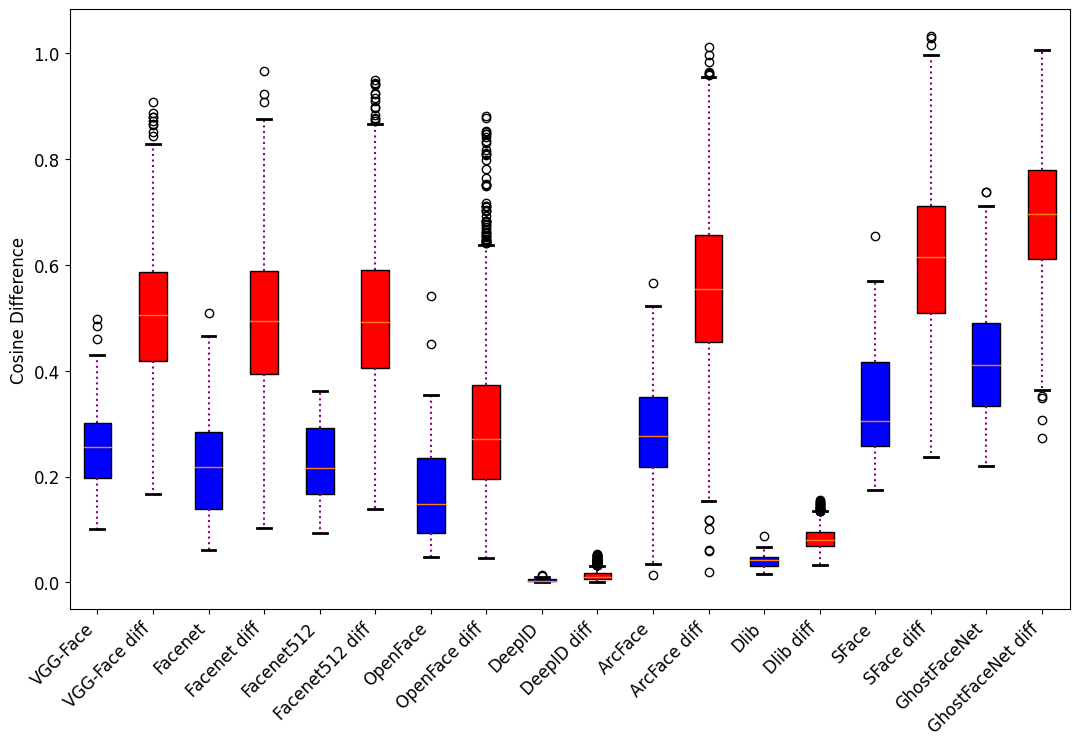

In [307]:
plot_results_model(full_results_same, full_diff_results)
# plot_results_model(full_results_same_euc, full_diff_results_euc)
# plot_results_model(full_results_same_l2, full_diff_results_l2)

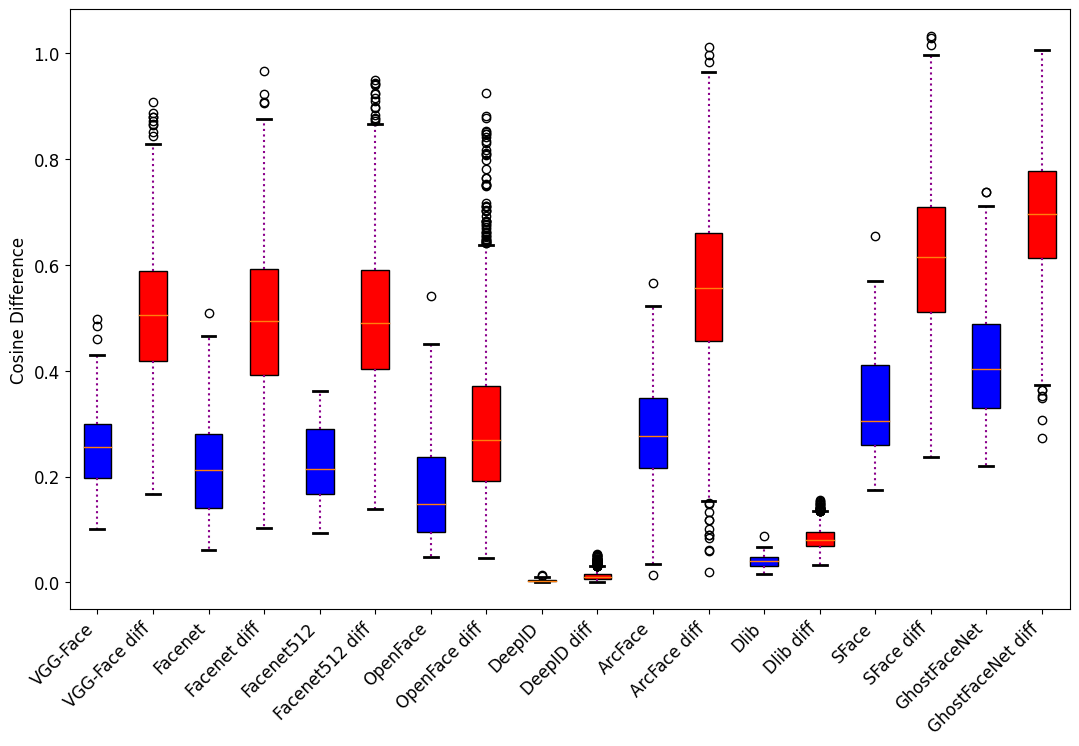

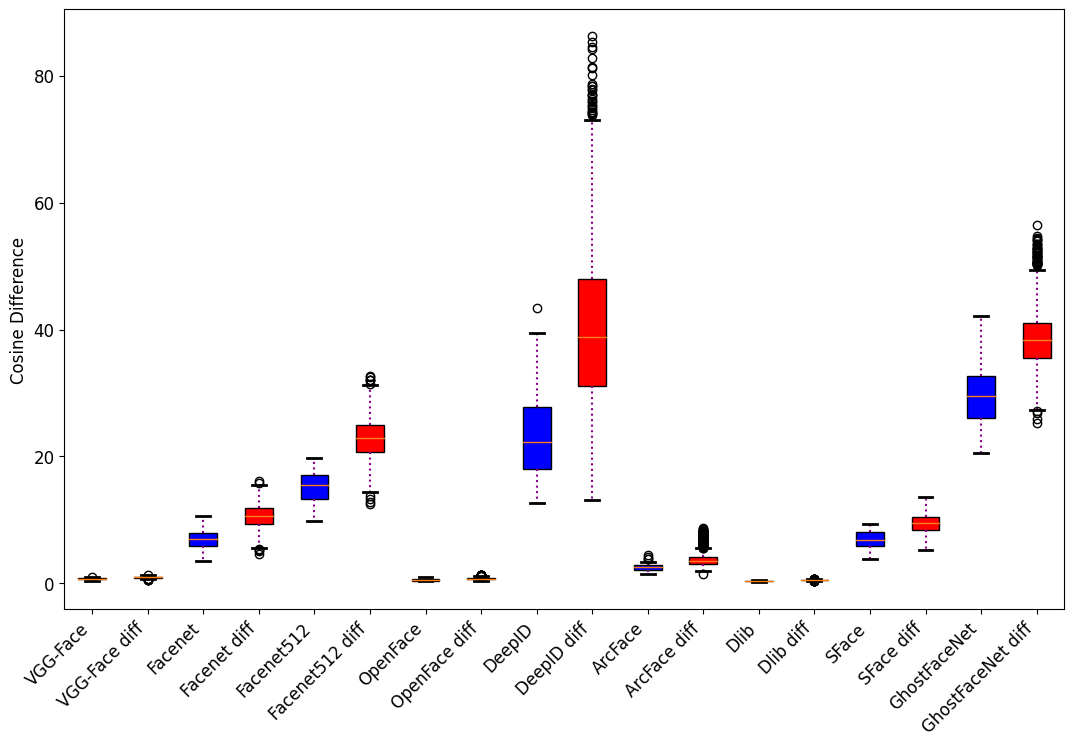

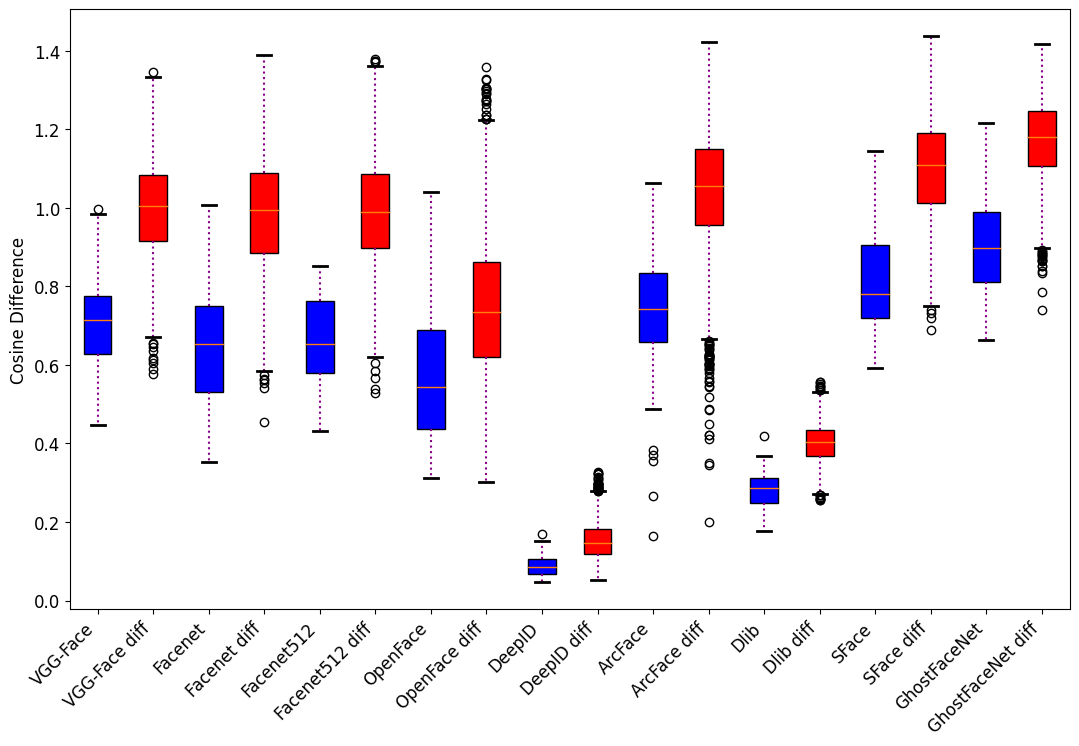

In [55]:
plot_results_model(full_results_same, full_diff_results)
plot_results_model(full_results_same_euc, full_diff_results_euc)
plot_results_model(full_results_same_l2, full_diff_results_l2)

### Setting a threshold

In [16]:
emb_dict = get_facial_embeddings(PATH,[p for p in list_all if p not in undetected],indx=['1','2','A'],model='Facenet512')

478 A : No face detected
633 A : No face detected
694 A : No face detected
964 A : No face detected
1892 A : No face detected
2037 A : No face detected


In [363]:
skip =['70','452','467','908','964','1763','1955']

In [251]:
skip

['1763', '1955', '35', '452', '467', '638', '70', '908', '964']

In [252]:
same_dict, same_list =  get_same_distances_dict(emb_dict, '1', '2', 'cosine',skip=skip)
diff_dict, diff_list =  get_diff_distances_dict(emb_dict,'cosine',skip=skip)
anon_dict, anon_list =  get_same_distances_dict(emb_dict, 'A', '2', 'cosine',skip=skip+undetected+['1502'])

19
54
59
81
118
272
274
437
447
448
454
459
462
469
473
474
478
483
518
600
625
628
633
644
651
662
673
685
694
723
734
738
755
770
773
786
790
820
833
838
848
892
910
937
945
946
961
965
973
1167
1255
1288
1314
1511
1552
1888
1892
1949
1987
2017
2027
2037
2041
2056
2058
2061
721
1502
19
54
59
81
118
272
274
437
447
448
454
459
462
469
473
474
478
483
518
600
625
628
633
644
651
662
673
685
694
723
734
738
755
770
773
786
790
820
833
838
848
892
910
937
945
946
961
965
973
1167
1255
1288
1314
1511
1552
1888
1892
1949
1987
2017
2027
2037
2041
2056
2058
2061
721


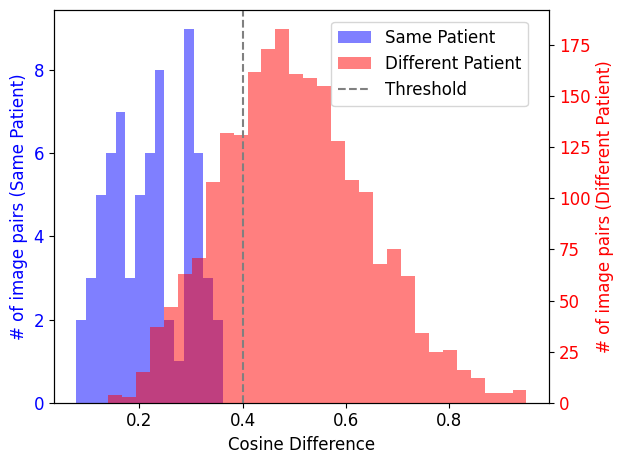

In [253]:
plot_hist(same_list,diff_list,density=True)

In [254]:
plot_two_whiskers(full_results_same['Facenet512'],full_diff_results['Facenet512'])

NameError: name 'full_results_same' is not defined

In [255]:
optimal_threshold = get_optimal_threshold(same_list,diff_list)

The optimal threshold is: 0.3310264075361308


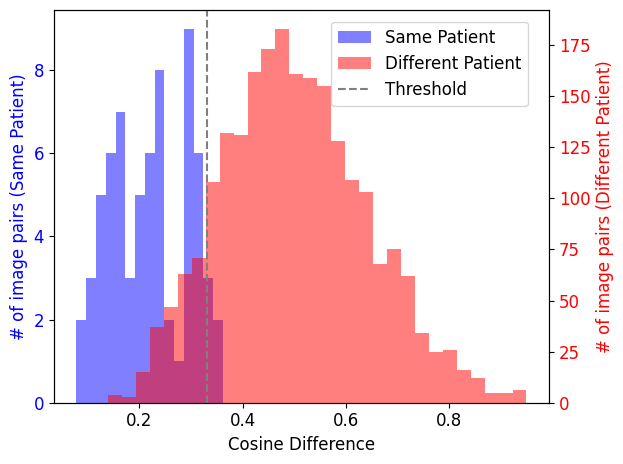

In [256]:
plot_hist(same_list,diff_list,density=True,threshold=optimal_threshold)

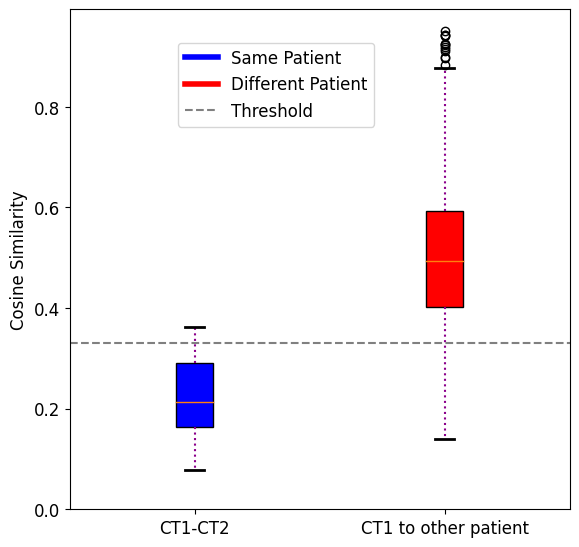

In [257]:
plot_two_whiskers(same_list,diff_list,threshold=optimal_threshold)

In [258]:
undetected

['638', '35']

In [281]:
num_matches_s = 0
num_total_s = 0
for p in same_dict.keys():
    num_total_s+=1
    if same_dict[p] > optimal_threshold:
        num_matches_s+=1
        print(p, same_dict[p])

54 0.3553012077712828
2027 0.36222532177554234


In [282]:
# skip = skip +  ['70','452','467','908','1763','1955','964','1167']
# skip = skip + ['1552']

In [283]:
print(num_matches_s, "/", num_total_s,"=",num_matches_s/num_total_s)

2 / 68 = 0.029411764705882353


In [278]:
list_below = []
num_matches = 0
num_total = 0
for p1 in diff_dict.keys():
    for p2 in diff_dict[p1]:
        num_total += 1
        if diff_dict[p1][p2] < optimal_threshold:
            print(p1, p2, diff_dict[p1][p2])
            list_below.append(p1)
            list_below.append(p2)
            num_matches+=1

19 59 0.2775491012394914
19 81 0.3289197367703025
19 447 0.25018885280922243
19 454 0.2561258998374921
19 462 0.31404393463184
19 469 0.21979985754476572
19 473 0.31369347165604944
19 483 0.1394715028446032
19 600 0.32258190406416487
19 651 0.3249325630514288
19 734 0.2943726043846008
19 770 0.2881017106171301
19 2058 0.28320554956032207
59 447 0.2685700795114022
59 469 0.26592621607450584
59 755 0.29343589009728843
59 770 0.22924631372065485
59 945 0.32348685862501647
59 1255 0.24045927971774506
59 1888 0.29060216885343515
81 118 0.20947598442875393
81 437 0.26421788138932123
81 447 0.2939837315133699
81 454 0.29692673033074746
81 469 0.22835989441753113
81 770 0.2703511832283214
81 1255 0.28777397328755927
81 2027 0.2513594759744404
118 437 0.25715742073725345
118 447 0.25091617231059204
118 448 0.24610020881824612
118 454 0.29195990359855206
118 469 0.21223404208020014
118 892 0.3277230901366226
118 965 0.32262724670802756
118 1255 0.22106478791785167
118 1511 0.3148957062500065
118

In [279]:
print(num_matches, "/", num_total,"=",num_matches/num_total)

247 / 2278 = 0.10842844600526778


In [280]:
len(list_all) - len(skip)


67

In [265]:
count_dict = dict(Counter(list_below))
dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))

{'1552': 22,
 '447': 19,
 '892': 19,
 '738': 19,
 '673': 16,
 '469': 15,
 '2058': 15,
 '1888': 15,
 '19': 13,
 '644': 13,
 '1288': 13,
 '118': 11,
 '1511': 11,
 '685': 11,
 '946': 11,
 '694': 11,
 '473': 10,
 '651': 10,
 '945': 10,
 '1255': 10,
 '965': 10,
 '2061': 10,
 '81': 9,
 '483': 9,
 '755': 9,
 '59': 8,
 '454': 8,
 '770': 8,
 '1167': 8,
 '600': 7,
 '1987': 7,
 '973': 7,
 '628': 7,
 '721': 7,
 '1949': 7,
 '1892': 7,
 '2041': 6,
 '833': 6,
 '1314': 6,
 '838': 6,
 '734': 5,
 '2056': 5,
 '790': 5,
 '773': 5,
 '274': 4,
 '662': 4,
 '848': 4,
 '478': 4,
 '462': 3,
 '272': 3,
 '625': 3,
 '786': 3,
 '937': 3,
 '437': 2,
 '2027': 2,
 '448': 2,
 '459': 2,
 '723': 2,
 '820': 2,
 '910': 1,
 '474': 1,
 '2037': 1,
 '961': 1,
 '2017': 1}

In [266]:
list_A = []
for f in [x.split("_")[0] for x in os.listdir(PATH) if "_A" in x]:
    list_A.append(f)
list_A.sort(key = int)
# print(len(list_all))

list_todo = []
for p in list_all:
    if p  not in list_A and p not in skip:
        list_todo.append(p)
        

In [401]:
list_todo

['638', '1502']

### Anonymization

In [382]:
emb_dict = get_facial_embeddings(PATH,[p for p in list_all if p not in undetected],indx=['1','2','A'],model='Facenet512')

478 A : No face detected
633 A : No face detected
694 A : No face detected
964 A : No face detected
1892 A : No face detected
2037 A : No face detected


In [327]:
anon_dict, anon_list =  get_same_distances_dict(emb_dict, 'A', '2', 'cosine',skip=skip)

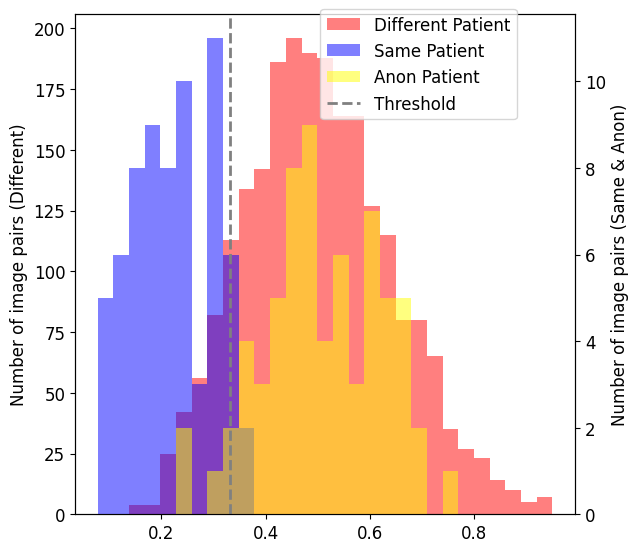

In [284]:
plot_hist_x3x3([same_list], [diff_list],[anon_list],threshold=optimal_threshold)

In [ ]:
# emb_dict

In [267]:
total_A = 0
total_id_A = 0
for p in anon_dict:
    total_A+=1
    if anon_dict[p] < optimal_threshold:
        print(p, anon_dict[p])
        total_id_A+=1

274 0.305320297265928
838 0.2555946552797079
1167 0.2387253969176445


In [268]:
for p in same_dict:
    if same_dict[p] > 0.4:
        print(p, same_dict[p])

In [269]:
same_dict['638']

KeyError: '638'

In [270]:
len(list_all) - len(skip) - len(undetected)

65

In [274]:
same = []

for p in [x for x in emb_dict.keys() if x not in skip and x != '1502']:
    emb_A = emb_dict[p]['A'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    # print("*****")
    # print(p)
    num_matches=0
    for p2 in [x for x in emb_dict.keys() if x not in skip]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        # sim = np.dot(emb_A, emb_2) / (norm(emb_A) * norm(emb_2))

        sim =  verification.find_distance(emb_A, emb_2, 'cosine')
        # print(sim)
        if sim <optimal_threshold:
            num_matches+=1
            if p==p2:
                print("correct match found")

        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
    print(p,":", closest_p,"--->",closest_sim)
    print(num_matches,"MATCHES")
    print("-----------------------------")
    if p == closest_p:
        same.append(p)
        

print("MATCH FOR: =",same)

19 : 734 ---> 0.31626157682646183
1 MATCHES
-----------------------------
54 : 1167 ---> 0.45593595932101516
0 MATCHES
-----------------------------
59 : 1552 ---> 0.44313400601222397
0 MATCHES
-----------------------------
81 : 447 ---> 0.3460501191320059
0 MATCHES
-----------------------------
118 : 2041 ---> 0.361348230986567
0 MATCHES
-----------------------------
272 : 1552 ---> 0.42354749047682105
0 MATCHES
-----------------------------
correct match found
274 : 694 ---> 0.28165441380640177
4 MATCHES
-----------------------------
437 : 437 ---> 0.3505773416658722
0 MATCHES
-----------------------------
447 : 738 ---> 0.3353585505558049
0 MATCHES
-----------------------------
448 : 961 ---> 0.3164237924269906
1 MATCHES
-----------------------------
454 : 478 ---> 0.48596854228850284
0 MATCHES
-----------------------------
459 : 1167 ---> 0.45443467171556196
0 MATCHES
-----------------------------
462 : 1511 ---> 0.2418209629473601
1 MATCHES
-----------------------------
469 : 734 

In [276]:
same = []
ps_off = []

for p in [x for x in emb_dict.keys() if x not in skip and x != '1502']:
    emb_A = emb_dict[p]['A'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    # print("*****")
    # print(p)
    num_matches=0
    for p2 in [x for x in emb_dict.keys() if x not in skip]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        sim =  verification.find_distance(emb_A, emb_2, 'cosine')
        
        if p2 != p:
            emb_3 = emb_dict[p2]['1'][0]['embedding']
            sim3 =  verification.find_distance(emb_A, emb_3, 'cosine')
        # sim = np.dot(emb_A, emb_2) / (norm(emb_A) * norm(emb_2))

      
        # print(sim)
        if sim <optimal_threshold:
            print(p2,sim)
            ps_off.append(p2)
            num_matches+=1
            if p==p2:
                print("correct match found!!!!")
        
        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
        if p2 != p:
            if sim3 <optimal_threshold:
                ps_off.append(p2)
                num_matches+=1
                print(p2,sim3)
            if sim3 < closest_sim:
                closest_sim = sim3
                closest_p = p2
    if num_matches > 0:
        print(p,":", closest_p,"--->",closest_sim)
        print(num_matches,"MATCHES")
        print("-----------------------------")
    if p == closest_p:
        same.append(p)
        

print("MATCH FOR: =",same)

734 0.31626157682646183
19 : 734 ---> 0.31626157682646183
1 MATCHES
-----------------------------
54 0.3081393330778601
59 : 54 ---> 0.3081393330778601
1 MATCHES
-----------------------------
274 0.305320297265928
correct match found!!!!
685 0.32031248418894
694 0.28165441380640177
694 0.3240092652748129
965 0.32157659299290287
274 : 694 ---> 0.28165441380640177
5 MATCHES
-----------------------------
892 0.32228950232556286
447 : 892 ---> 0.32228950232556286
1 MATCHES
-----------------------------
518 0.32984030994210856
662 0.22604935234769175
961 0.3164237924269906
448 : 662 ---> 0.22604935234769175
3 MATCHES
-----------------------------
600 0.3188522726559837
773 0.30139346901844366
1511 0.2418209629473601
1502 0.29404053621572446
462 : 1511 ---> 0.2418209629473601
4 MATCHES
-----------------------------
1987 0.3170955672108875
469 : 1987 ---> 0.3170955672108875
1 MATCHES
-----------------------------
755 0.2965929037166767
473 : 755 ---> 0.2965929037166767
1 MATCHES
-------------

In [108]:
off_d = dict(Counter(ps_off))
dict(sorted(off_d.items(), key=lambda item: item[1], reverse=True))

{'1288': 7,
 '1167': 7,
 '694': 6,
 '628': 6,
 '1949': 5,
 '685': 4,
 '662': 4,
 '2061': 4,
 '892': 3,
 '961': 3,
 '673': 3,
 '790': 3,
 '734': 2,
 '518': 2,
 '600': 2,
 '773': 2,
 '1511': 2,
 '1987': 2,
 '755': 2,
 '2056': 2,
 '478': 2,
 '644': 2,
 '848': 2,
 '54': 1,
 '274': 1,
 '965': 1,
 '2058': 1,
 '2027': 1,
 '454': 1,
 '1892': 1,
 '838': 1,
 '625': 1,
 '738': 1}

In [275]:
same = []
diff = []
offenders = []
off = ['937']#['625','662']
same23 = []
for p in [x for x in emb_dict.keys() if x not in skip and x not in off]:
    
    emb_A = emb_dict[p]['1'][0]['embedding']
    closest_sim = 1
    closest_p = ''
    closest_sim2 = 1
    closest_p2 = ''
    closest_sim3 = 1
    closest_p3 = ''
    # print("*****")
    # print(p)
    num_matches = 0
    for p2 in [x for x in emb_dict.keys() if x not in skip and x not in off]:
        # print(p2)
        emb_2 = emb_dict[p2]['2'][0]['embedding']
        sim = verification.find_distance(emb_A, emb_2, 'cosine')
        if sim<optimal_threshold:
            num_matches+=1
        if p == p2:
            print("Same p:",sim)
        # print("       "+p2 +": "+ str(sim))
        if sim < closest_sim:
            closest_sim = sim
            closest_p = p2
        elif sim < closest_sim2:
            closest_sim2 = sim
            closest_p2 = p2
        elif sim < closest_sim3:
            closest_sim3 = sim
            closest_p3 = p2
    print(p,":", closest_p, closest_p2, closest_p3)
    print("clostest p:",closest_sim)
    print(num_matches, "MATCHES")
    print("********")
    if p == closest_p:
        same.append(p)
    elif p== closest_p2 or p==closest_p3:
        same23.append(p)
    
    else:
        diff.append(p)
        offenders.append(p)
        offenders.append(closest_p)
        offenders.append(closest_p2)
        offenders.append(closest_p3)

print("NOT A MATCH FOR: ",len(diff),"PATIENTS =",diff)

print("Direct match for:", same)
print("2nd 3rd match for:",same23)

Same p: 0.1317052933736601
19 : 19 770 600
clostest p: 0.1317052933736601
14 MATCHES
********
Same p: 0.3553012077712828
54 : 59 1552 2056
clostest p: 0.35423449669062756
0 MATCHES
********
Same p: 0.2693015382267838
59 : 1255 945 786
clostest p: 0.1612511368067232
9 MATCHES
********
Same p: 0.209385800967687
81 : 81 474 945
clostest p: 0.209385800967687
14 MATCHES
********
Same p: 0.17436911038152536
118 : 118 474 462
clostest p: 0.17436911038152536
17 MATCHES
********
Same p: 0.2470585598951337
272 : 272 738 973
clostest p: 0.2470585598951337
4 MATCHES
********
Same p: 0.1379795133503613
274 : 478 454 1987
clostest p: 0.13119912320271399
6 MATCHES
********
Same p: 0.2591133287212748
437 : 474 2037 1255
clostest p: 0.23433803442709544
3 MATCHES
********
Same p: 0.21322523237785052
447 : 19 600 738
clostest p: 0.17580999909250272
22 MATCHES
********
Same p: 0.23738113533244976
448 : 448 965 478
clostest p: 0.23738113533244976
3 MATCHES
********
Same p: 0.2895367040919342
454 : 59 945 6

In [110]:
offenders_dict = dict(Counter(offenders))
dict(sorted(offenders_dict.items(), key=lambda item: item[1], reverse=True))

{'973': 5,
 '1511': 4,
 '946': 4,
 '59': 3,
 '2056': 3,
 '1255': 3,
 '945': 3,
 '600': 3,
 '738': 3,
 '651': 3,
 '790': 3,
 '820': 3,
 '1288': 3,
 '478': 2,
 '454': 2,
 '1987': 2,
 '474': 2,
 '447': 2,
 '1949': 2,
 '1892': 2,
 '2027': 2,
 '965': 2,
 '54': 1,
 '1167': 1,
 '786': 1,
 '274': 1,
 '437': 1,
 '2037': 1,
 '19': 1,
 '2058': 1,
 '518': 1,
 '961': 1,
 '2017': 1,
 '662': 1,
 '673': 1,
 '685': 1,
 '734': 1,
 '755': 1,
 '773': 1,
 '833': 1,
 '483': 1}

### Add random faces

In [57]:
PATH_real= PATH + 'faces/'

In [58]:
reals = os.listdir(PATH_real)
print(reals)

['1 (21).png', '1 (16).png', '1 (13).png', '1 (34).png', '1 (10).png', '1 (10).jpg', '1 (30).jpg', '1 (16).jpg', '1 (30).png', '1 (32).jpg', '1 (5).png', '1 (3).jpg', '1 (21).jpg', '1 (22).png', '1 (29).jpg', '1 (23).png', '1 (29).jpeg', '1 (12).jpg', '1 (17).jpeg', '1 (14).jpg', '1 (27).jpeg', '1 (31).jpg', '1 (28).jpg', '1 (2).png', '1 (32).png', '1 (5).jpeg', '1 (31).png', '1 (13).jpg', '1 (18).png', '1 (23).jpeg', '1 (6).png', '1 (3).jpeg', '1 (20).jpeg', '1 (19).png', '1 (22).jpeg', '1 (5).jpg', '1 (7).png', '1 (30).jpeg', '1 (18).jpeg', '1 (3).png', '1 (35).jpg', '1 (20).png', '1 (8).jpeg', '1 (15).png', '1 (12).jpeg', '1 (9).jpg', '1 (35).jpeg', '1 (7).jpeg', '1 (11).png', '1 (34).jpg', '1 (15).jpg', '1 (31).jpeg', '1 (26).png', '1 (33).jpg', '1 (19).jpg', '1 (22).jpg', '1 (27).png', '1 (25).jpeg', '1 (14).jpeg', '1 (9).jpeg', '1 (23).jpg', '1 (17).png', '1 (2).jpg', '1 (24).jpg', '1 (16).jpeg', '1 (24).jpeg', '1 (13).jpeg', '1 (33).png', '1 (2).jpeg', '1 (15).jpeg', '1 (32).jpe

In [60]:
# for r in reals:
#     new_strnig = r.split("(")[1].split(")")[0]
#     print(new_strnig)

In [62]:
emb_dict_real = {}


for person in reals:
    emb_dict_real[person]= DeepFace.represent(img_path = PATH_real+person, enforce_detection=True,detector_backend='retinaface',model_name='Facenet512') 


In [65]:

    
dist_dict = {}
dist_list = []
list_to_do = [p for p in list(emb_dict.keys()) if p not in skip]
for p1 in [p for p in list(emb_dict.keys()) if p not in skip and p not in undetected] :
  
    dist_dict[p1] = {}
    for p2 in reals:            

        v_a = emb_dict[p1]['1'][0]['embedding']
        v_b = emb_dict_real[p2][0]['embedding']
        # to do -- change 0 to be taken before
        
        dist = verification.find_distance(v_a, v_b, 'cosine')
      
        dist_dict[p1][p2] = dist
        dist_list.append(dist)
    

In [66]:
dist_list

[0.9491717050806447,
 1.177703438460719,
 0.8354273714419547,
 0.9425443254945878,
 0.9975614888487212,
 0.752873040447733,
 1.0848796174928306,
 1.0489468855719752,
 0.7613663695121767,
 0.8579296063194712,
 0.9551889914957632,
 0.7926638596396718,
 1.0398642031248322,
 0.9551889914957632,
 1.056728215094433,
 0.9551889914957632,
 0.9915813865916661,
 1.04715960755995,
 1.0348888890698709,
 0.9045461954302301,
 0.9580536051872975,
 0.9721105243295414,
 0.9584741546650151,
 0.9551889914957632,
 0.8843171459656912,
 0.9169076921553102,
 1.2357750697725696,
 0.8303643222035926,
 0.9551889914957632,
 1.132612733474891,
 0.924332025147952,
 1.0348888890698709,
 1.0341938264712407,
 0.9551889914957632,
 1.1307320607797324,
 0.9494428684551156,
 0.9792903616343429,
 0.9550352269804947,
 1.1222300009062736,
 0.7613663695121767,
 0.8184355838628364,
 0.9425443254945878,
 1.1222300009062736,
 0.9425443254945878,
 1.1222300009062736,
 0.9494428684551156,
 1.0132389635499148,
 0.6793691288602247,

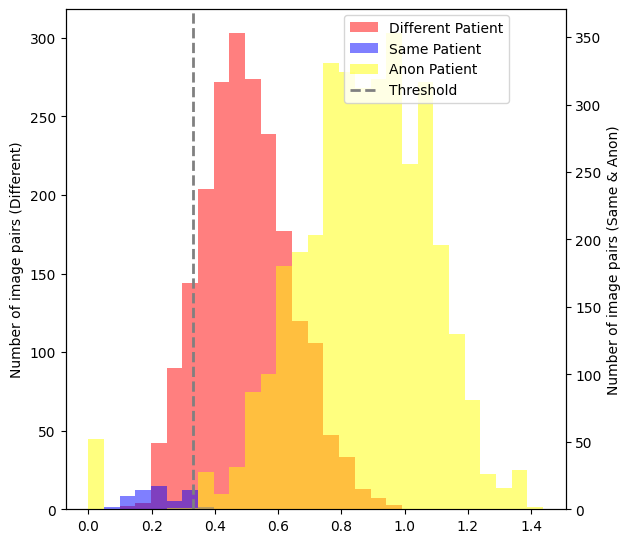

In [91]:
plot_hist_x3x3([same_list], [diff_list],[dist_list2],threshold=optimal_threshold)

In [68]:
r_8 = DeepFace.represent(img_path = PATH+'Untitled.png', enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')

In [73]:
r = r_8[0]['embedding']
f = emb_dict['838']['1'][0]['embedding']

In [75]:
verification.find_distance(r,f,'cosine')

0.8222483647293588

In [81]:
import tensorflow as tf

# Load the pre-trained FaceNet512 model
model = DeepFace.build_model('Facenet512')

# Set the layers you want to fine-tune to be trainable
for layer in model.layers:
    layer.trainable = False  # Freeze all layers
model.layers[-2].trainable = True  # Unfreeze the last layer for fine-tuning

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy')

# Train the model on your dataset
model.fit(train_data, train_labels, epochs=10, batch_size=32)

AttributeError: 'FaceNet512dClient' object has no attribute 'layers'

In [82]:
model

In [84]:
print(model.keys())


AttributeError: 'FaceNet512dClient' object has no attribute 'keys'

In [85]:
from tensorflow.keras import layers, models

In [86]:
base_model = model

In [87]:
x = base_model.output

AttributeError: 'FaceNet512dClient' object has no attribute 'output'

In [90]:
dist_dict2 = {}
dist_list2 = []
list_to_do = reals
for p1 in reals :
    list_to_do.remove(p1)
    dist_dict2[p1] = {}
    for p2 in list_to_do:            

        v_a = emb_dict_real[p1][0]['embedding']
        v_b = emb_dict_real[p2][0]['embedding']
        # to do -- change 0 to be taken before
        
        dist = verification.find_distance(v_a, v_b, 'cosine')
      
        dist_dict2[p1][p2] = dist
        dist_list2.append(dist)
        

In [114]:
def process_images(p, path):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    image_paths = [f"{path}{p}_1.png", f"{path}{p}_2.png", f"{path}{p}_A.png"]
    titles = [f"Patient: {p} - Image 1", f"Patient: {p} - Image 2", f"Patient: {p} - Image A"]
    results = []
    
    for i, image_path in enumerate(image_paths):
        try:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            detect = DeepFace.extract_faces(image_path, detector_backend='retinaface')
            facial_area = detect[0]['facial_area']
            confidence = detect[0]['confidence']
            
            x, y, w, h = facial_area['x'], facial_area['y'], facial_area['w'], facial_area['h']
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (36, 255, 12), 1)
            
            left_eye = facial_area['left_eye']
            right_eye = facial_area['right_eye']
            
            ax = axes[i]
            ax.imshow(image)
            ax.scatter(*left_eye, color='red', s=50, label='Left Eye')
            ax.scatter(*right_eye, color='blue', s=50, label='Right Eye')
            ax.set_title(titles[i])
            ax.axis('off')
            ax.legend()
            
            results.append(f"{titles[i]}: {facial_area}, {confidence}")
        except Exception as e:
            results.append(f"{titles[i]}: No face detected or error: {e}")
    
    plt.tight_layout()
    plt.show()
    return results

# for p in [l for l in list_all if l not in skip]:
#     print(p)
#     results = process_images(p, PATH)
#     print(" | ".join(results))

In [323]:
# for p in [l for l in list_all if l not in undetected]:
#     print(p)
#     results = process_images(p, PATH)
#     print(" | ".join(results))

In [116]:
# 467
# 478 no img found
#633 eyes, no img found
#694 no img
#1892 no img
# 2037 no img



In [119]:
skip.remove('35')

In [118]:
undetected

['638', '721', '1502', '35']

In [193]:
skip.sort()
print(skip)

['1552', '1763', '1955', '35', '452', '467', '638', '70', '908', '964']


In [245]:
p='1552'
a=DeepFace.represent(img_path = PATH+p+"_1"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')[0]['embedding']


In [246]:
b=DeepFace.represent(img_path = PATH+p+"_2"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')[0]['embedding']

In [247]:
verification.find_distance(a,b,'cosine')

0.19385360487644954

In [186]:
skip

['638', '35', '70', '452', '467', '908', '1763', '1955', '964', '1552']

In [173]:
for p in ['721','1502']:
    emb_dict[p] = {}
    emb_dict[p]['1'] =DeepFace.represent(img_path = PATH+p+"_1"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')
    emb_dict[p]['2'] =DeepFace.represent(img_path = PATH+p+"_2"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')
    emb_dict[p]['A'] =DeepFace.represent(img_path = PATH+p+"_A"+".png", enforce_detection=True,detector_backend='retinaface',model_name='Facenet512')

ValueError: Confirm that /mnt/iDriveShare/Kayla/CBCT_images/anonymized/screenshots/1502_A.png exists

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from scipy.stats import levene

# Generate t-SNE representation
def compute_tsne(embeddings, perplexity=50):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_results = tsne.fit_transform(np.array(embeddings))
    return tsne_results

# Compute mean deviation
def compute_deviations(points, centroid):
    deviations = np.linalg.norm(points - centroid, axis=1)
    return deviations

# Plot t-SNE and calculate deviations
def plot_tsne_clusters(dict_emb, num=['1', '2'], skip=[],perplexity=30,plot=True):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)
    
    tsne_results = compute_tsne(X,perplexity)
    df_tsne = pd.DataFrame(tsne_results, columns=['x', 'y'])
    df_tsne['label'] = labels
    df_tsne['n_labels'] = n_labels
    
   
    # Create a custom palette dictionary
    unique_labels = np.unique(labels)
 
    # Calculate centroids and deviations
    within_cluster_devs = []
    centroids = []
    
    for label in unique_labels:
        cluster_points = tsne_results[df_tsne['label'] == label]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)
    
    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))
    
    # Levene's test for variance equality
    stat, p_value = levene(*within_cluster_devs)
    
    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: { np.mean(between_cluster_dev) /np.mean([np.mean(dev) for dev in within_cluster_devs])}")

    if plot:
        fig, ax = plt.subplots(figsize=(10, 8))
        colours = [
            '#FF0000', '#0000FF', '#FF00FF', '#00FFFF', '#FFA500', '#00FF00', '#FFFF00', '#008000', '#800080', '#FA8072',
            '#5F9EA0', '#808000', '#FFC0CB', '#A52A2A', '#000000', '#46dee4', '#808080', '#000080', '#008080', '#800000',
            '#FFD700', '#C0C0C0', '#FF7F50', '#4B0082', '#EE82EE', '#40E0D0', '#F0E68C', '#E6E6FA', '#228B22', '#F5F5DC',
            '#DC143C', '#FF00FF', '#87CEEB', '#7FFF00', '#D2691E', '#98FF98', '#FFE5B4', '#DA70D6', '#e1feaf', '#007FFF',
            '#50C878', '#E0115F', '#0F52BA', '#D2B48C', '#CCCCFF', '#FFDB58', '#FBCEB1', '#D8BFD8', '#007BA7', '#F5DEB3',
            '#DE5D83', '#B87333', '#FFF700', '#A0522D', '#4605f6', '#FF6347', '#36454F', '#00FFFF', '#9966CC','#535970',
            '#2a8373','#7e338e','#73d635','#93550a','#fb17a8','#a6c878','#4a29a9','#3d5c92'
        ]
    
        palette = dict(zip(unique_labels, colours[:len(unique_labels)]))
        
        sns.scatterplot(x='x', y='y', s=75, hue='label', palette=palette, data=df_tsne, ax=ax)
        x = df_tsne['x'].values
        y = df_tsne['y'].values
        
        # Add text annotations
        for i, txt in enumerate(df_tsne['label']):
            if df_tsne['n_labels'][i] == 'A':
                txt = txt +"_A"
            plt.text(x[i], y[i], txt, fontsize=8, ha='center', va='bottom')
                
                    
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.show()

Within-cluster deviation: 1.8990356922149658
Between-cluster deviation: 9.187139511108398
P-value: 6.750092425619124e-21
Ratio between cluster/within cluster deviation: 4.837791919708252


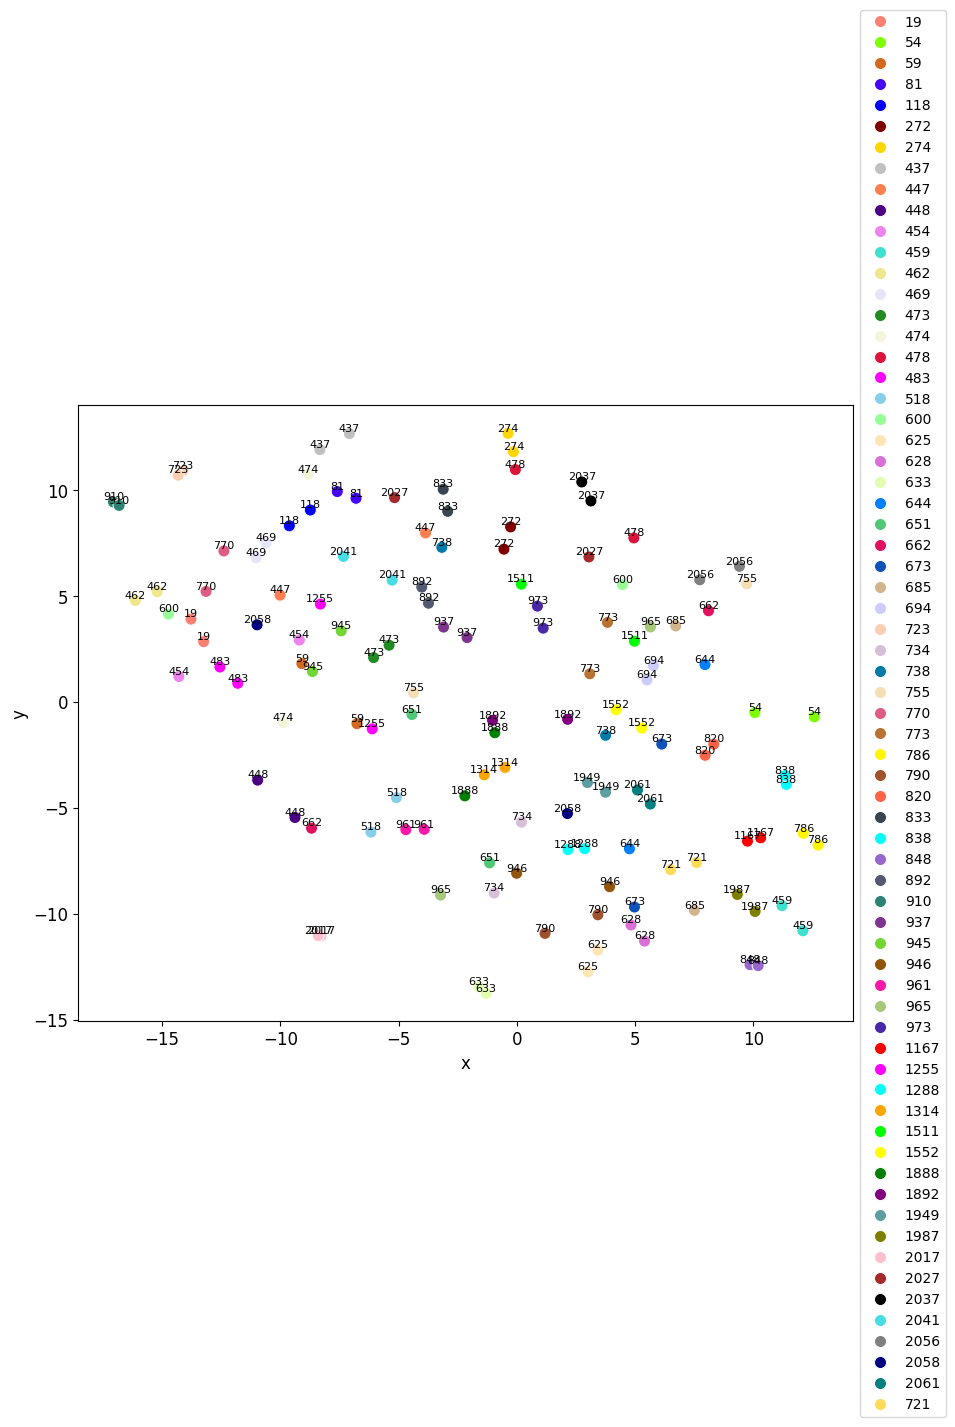

In [322]:
plot_tsne_clusters(emb_dict,['1','2'],skip=skip+['1502'],perplexity=20)

Within-cluster deviation: 7.802977561950684
Between-cluster deviation: 4.775347709655762
P-value: 0.1356428708463416
Ratio between cluster/within cluster deviation: 0.6119904518127441


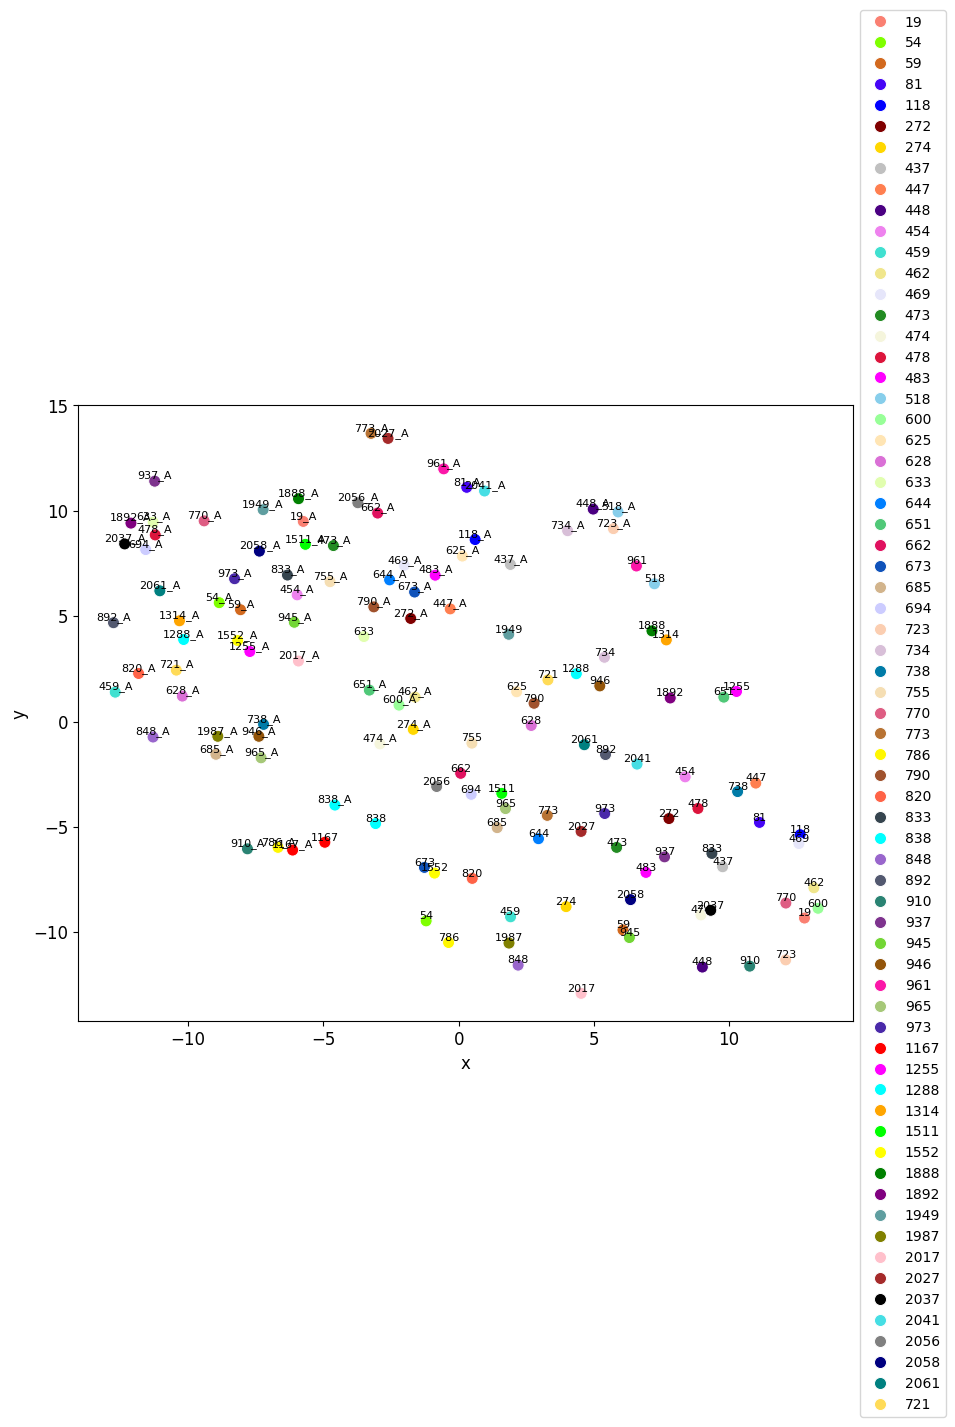

In [290]:
plot_tsne_clusters(emb_dict,['A','2'],skip=skip+['1502'],perplexity=20)

In [294]:
def get_cluster_dists(num, dict_emb):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip + ['1502']]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)

    # Here, we skip the t-SNE part and use the embeddings directly
    df_emb = pd.DataFrame(X)
    df_emb['label'] = labels
    df_emb['n_labels'] = n_labels

    within_cluster_devs = []
    centroids = []

    unique_labels = df_emb['label'].unique()
    for label in unique_labels:
        cluster_points = df_emb[df_emb['label'] == label].iloc[:, :-2]  # Exclude label columns
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)

    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))

   

    # Levene's test for variance equality
    print("Debug info: ", within_cluster_devs)  # Add this line
    stat, p_value = levene(*within_cluster_devs)

    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: {np.mean(between_cluster_dev) / np.mean([np.mean(dev) for dev in within_cluster_devs])}")

In [298]:
get_cluster_dists(['1','2'],emb_dict)

Within-cluster deviation: 7.5483595483079915
Between-cluster deviation: 13.976041684850145
P-value: nan
Ratio between cluster/within cluster deviation: 1.851533647199272


In [297]:
get_cluster_dists(['A','2'],emb_dict)

Within-cluster deviation: 10.919963273825486
Between-cluster deviation: 12.253380580360304
P-value: nan
Ratio between cluster/within cluster deviation: 1.1221082226284536


In [296]:
from scipy.stats import bartlett

def get_cluster_dists(num, dict_emb):
    X = []
    labels = []
    n_labels = []
    for p in [x for x in dict_emb if x not in skip + ['1502']]:
        for n in num:
            X.append(dict_emb[p][n][0]['embedding'])
            labels.append(p)
            n_labels.append(n)

    df_emb = pd.DataFrame(X)
    df_emb['label'] = labels
    df_emb['n_labels'] = n_labels

    within_cluster_devs = []
    centroids = []

    unique_labels = df_emb['label'].unique()
    for label in unique_labels:
        cluster_points = df_emb[df_emb['label'] == label].iloc[:, :-2]
        centroid = np.mean(cluster_points, axis=0)
        centroids.append(centroid)
        deviations = compute_deviations(cluster_points, centroid)
        within_cluster_devs.append(deviations)

    between_cluster_dev = compute_deviations(np.array(centroids), np.mean(centroids, axis=0))

    # Bartlett's test for variance equality
    stat, p_value = bartlett(*within_cluster_devs)

    # Print deviations and p-value
    print(f"Within-cluster deviation: {np.mean([np.mean(dev) for dev in within_cluster_devs])}")
    print(f"Between-cluster deviation: {np.mean(between_cluster_dev)}")
    print(f"P-value: {p_value}")
    print(f"Ratio between cluster/within cluster deviation: {np.mean(between_cluster_dev) / np.mean([np.mean(dev) for dev in within_cluster_devs])}")


In [319]:
from scipy.spatial.distance import euclidean

def compare_pairs(dict_emb):
    distances_before = []
    distances_after = []
    for p in dict_emb:
        if p not in skip + ['1502']:
            before_embedding_1 = dict_emb[p]['1'][0]['embedding']
            before_embedding_2 = dict_emb[p]['2'][0]['embedding']
            after_embedding = dict_emb[p]['A'][0]['embedding']
            distance_before = euclidean(before_embedding_1,before_embedding_2)
            print(distance_before)
            distance_after = euclidean(before_embedding_2,after_embedding)
            distances_before.append(distance_before)
            distances_after.append(distance_after)
    
    mean_distance_before = np.mean(distances_before)
    mean_distance_after = np.mean(distances_after)
    
    print(f"Mean distance before defacing: {mean_distance_before}")
    print(f"Mean distance after defacing: {mean_distance_after}")



In [321]:
# compare_pairs(emb_dict)